In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define learning parameters

In [2]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [3]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 70672857.40it/s]


Extracting input/data/MNIST/raw/train-images-idx3-ubyte.gz to input/data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 107771969.59it/s]

Extracting input/data/MNIST/raw/train-labels-idx1-ubyte.gz to input/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 42519298.12it/s]

Extracting input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to input/data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11921482.33it/s]


Extracting input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to input/data/MNIST/raw



# Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [6]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [7]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [8]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [9]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [10]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)


In [11]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [12]:
## to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [13]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

# Q. Write training loop

118it [00:14,  8.23it/s]                         


Epoch 1 of 100
Generator loss: 1.30779457, Discriminator loss: 0.93409485


118it [00:15,  7.42it/s]                         


Epoch 2 of 100
Generator loss: 1.67656600, Discriminator loss: 1.30437911


118it [00:14,  8.41it/s]                         


Epoch 3 of 100
Generator loss: 4.94023514, Discriminator loss: 0.41126680


118it [00:14,  8.39it/s]                         


Epoch 4 of 100
Generator loss: 4.54391718, Discriminator loss: 0.69641525


118it [00:14,  8.43it/s]                         


Epoch 5 of 100
Generator loss: 3.42783165, Discriminator loss: 0.71866608


118it [00:13,  8.46it/s]                         


Epoch 6 of 100
Generator loss: 1.79191315, Discriminator loss: 1.15546620


118it [00:15,  7.82it/s]                         


Epoch 7 of 100
Generator loss: 2.83743024, Discriminator loss: 1.17078507


118it [00:14,  8.12it/s]                         


Epoch 8 of 100
Generator loss: 1.71380401, Discriminator loss: 1.05244315


118it [00:14,  8.09it/s]                         


Epoch 9 of 100
Generator loss: 2.33995318, Discriminator loss: 1.12944639


118it [00:14,  8.26it/s]                         


Epoch 10 of 100
Generator loss: 1.56116557, Discriminator loss: 1.11661601


118it [00:14,  8.12it/s]                         


Epoch 11 of 100
Generator loss: 1.48810196, Discriminator loss: 1.25789785


118it [00:14,  8.42it/s]                         


Epoch 12 of 100
Generator loss: 1.29697049, Discriminator loss: 1.10675395


118it [00:14,  8.30it/s]                         


Epoch 13 of 100
Generator loss: 1.51730561, Discriminator loss: 1.13597488


118it [00:15,  7.82it/s]                         


Epoch 14 of 100
Generator loss: 1.65340400, Discriminator loss: 1.14795649


118it [00:14,  8.32it/s]                         


Epoch 15 of 100
Generator loss: 1.52399409, Discriminator loss: 0.95952892


118it [00:14,  8.38it/s]                         


Epoch 16 of 100
Generator loss: 1.89520836, Discriminator loss: 1.03230572


118it [00:14,  8.17it/s]                         


Epoch 17 of 100
Generator loss: 1.09938383, Discriminator loss: 1.40162921


118it [00:14,  8.32it/s]                         


Epoch 18 of 100
Generator loss: 1.21220040, Discriminator loss: 1.27544415


118it [00:14,  8.18it/s]                         


Epoch 19 of 100
Generator loss: 0.89675230, Discriminator loss: 1.09192395


118it [00:14,  8.37it/s]                         


Epoch 20 of 100
Generator loss: 1.28249657, Discriminator loss: 1.07490897


118it [00:13,  8.45it/s]                         


Epoch 21 of 100
Generator loss: 2.22348070, Discriminator loss: 0.78815162


118it [00:13,  8.47it/s]                         


Epoch 22 of 100
Generator loss: 2.00423002, Discriminator loss: 0.68095487


118it [00:13,  8.47it/s]                         


Epoch 23 of 100
Generator loss: 1.96149051, Discriminator loss: 0.62438893


118it [00:13,  8.47it/s]                         


Epoch 24 of 100
Generator loss: 2.49650836, Discriminator loss: 0.48403141


118it [00:14,  8.41it/s]                         


Epoch 25 of 100
Generator loss: 2.49638867, Discriminator loss: 0.51547372


118it [00:14,  8.40it/s]                         


Epoch 26 of 100
Generator loss: 2.63807893, Discriminator loss: 0.47624782


118it [00:13,  8.74it/s]                         


Epoch 27 of 100
Generator loss: 2.49454284, Discriminator loss: 0.52985996


118it [00:14,  8.32it/s]                         


Epoch 28 of 100
Generator loss: 2.65780878, Discriminator loss: 0.57247877


118it [00:13,  8.45it/s]                         


Epoch 29 of 100
Generator loss: 3.00852370, Discriminator loss: 0.44233504


118it [00:14,  8.17it/s]                         


Epoch 30 of 100
Generator loss: 2.92263103, Discriminator loss: 0.52023268


118it [00:14,  8.24it/s]                         


Epoch 31 of 100
Generator loss: 2.35663795, Discriminator loss: 0.54156393


118it [00:14,  8.30it/s]                         


Epoch 32 of 100
Generator loss: 2.43798375, Discriminator loss: 0.62161070


118it [00:13,  8.50it/s]                         


Epoch 33 of 100
Generator loss: 2.61498690, Discriminator loss: 0.54052913


118it [00:13,  8.47it/s]                         


Epoch 34 of 100
Generator loss: 2.46803689, Discriminator loss: 0.59613353


118it [00:13,  8.45it/s]                         


Epoch 35 of 100
Generator loss: 2.59213185, Discriminator loss: 0.50385213


118it [00:13,  8.45it/s]                         


Epoch 36 of 100
Generator loss: 2.62818575, Discriminator loss: 0.64199311


118it [00:14,  8.43it/s]                         


Epoch 37 of 100
Generator loss: 2.70806575, Discriminator loss: 0.47094813


118it [00:13,  8.55it/s]                         


Epoch 38 of 100
Generator loss: 2.81160855, Discriminator loss: 0.52756321


118it [00:14,  8.38it/s]                         


Epoch 39 of 100
Generator loss: 2.30756688, Discriminator loss: 0.65394121


118it [00:13,  8.54it/s]                         


Epoch 40 of 100
Generator loss: 2.65576982, Discriminator loss: 0.47354120


118it [00:13,  8.45it/s]                         


Epoch 41 of 100
Generator loss: 2.31406283, Discriminator loss: 0.61923766


118it [00:13,  8.56it/s]                         


Epoch 42 of 100
Generator loss: 2.23345470, Discriminator loss: 0.63205439


118it [00:13,  8.45it/s]                         


Epoch 43 of 100
Generator loss: 2.92235708, Discriminator loss: 0.50461167


118it [00:13,  8.58it/s]                         


Epoch 44 of 100
Generator loss: 2.90902185, Discriminator loss: 0.51740402


118it [00:13,  8.48it/s]                         


Epoch 45 of 100
Generator loss: 2.57297063, Discriminator loss: 0.56984758


118it [00:13,  8.52it/s]                         


Epoch 46 of 100
Generator loss: 2.85455155, Discriminator loss: 0.49320361


118it [00:13,  8.49it/s]                         


Epoch 47 of 100
Generator loss: 2.81323767, Discriminator loss: 0.51728362


118it [00:14,  8.37it/s]                         


Epoch 48 of 100
Generator loss: 2.91488671, Discriminator loss: 0.50453663


118it [00:13,  8.49it/s]                         


Epoch 49 of 100
Generator loss: 2.87426281, Discriminator loss: 0.50076711


118it [00:13,  8.47it/s]                         


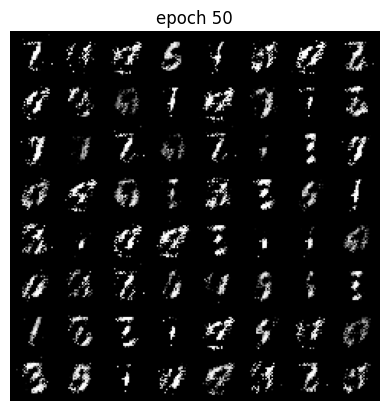

Epoch 50 of 100
Generator loss: 2.98979688, Discriminator loss: 0.49610472


118it [00:13,  8.62it/s]                         


Epoch 51 of 100
Generator loss: 2.84263873, Discriminator loss: 0.54741251


118it [00:14,  8.34it/s]                         


Epoch 52 of 100
Generator loss: 2.91011286, Discriminator loss: 0.50564003


118it [00:13,  8.44it/s]                         


Epoch 53 of 100
Generator loss: 2.92901158, Discriminator loss: 0.52589291


118it [00:13,  8.46it/s]                         


Epoch 54 of 100
Generator loss: 2.87415338, Discriminator loss: 0.52585930


118it [00:13,  8.46it/s]                         


Epoch 55 of 100
Generator loss: 2.69466257, Discriminator loss: 0.63267094


118it [00:13,  8.47it/s]                         


Epoch 56 of 100
Generator loss: 2.49256587, Discriminator loss: 0.63388240


118it [00:13,  8.44it/s]                         


Epoch 57 of 100
Generator loss: 2.68816161, Discriminator loss: 0.52603567


118it [00:14,  8.40it/s]                         


Epoch 58 of 100
Generator loss: 2.62032866, Discriminator loss: 0.58609998


118it [00:13,  8.63it/s]                         


Epoch 59 of 100
Generator loss: 2.50556970, Discriminator loss: 0.65812230


118it [00:13,  8.54it/s]                         


Epoch 60 of 100
Generator loss: 2.30822015, Discriminator loss: 0.68393475


118it [00:13,  8.52it/s]                         


Epoch 61 of 100
Generator loss: 2.58276176, Discriminator loss: 0.56238431


118it [00:13,  8.50it/s]                         


Epoch 62 of 100
Generator loss: 2.69830894, Discriminator loss: 0.54195839


118it [00:14,  8.42it/s]                         


Epoch 63 of 100
Generator loss: 2.43094397, Discriminator loss: 0.66250074


118it [00:13,  8.72it/s]                         


Epoch 64 of 100
Generator loss: 2.34888577, Discriminator loss: 0.67038536


118it [00:13,  8.53it/s]                         


Epoch 65 of 100
Generator loss: 2.55954409, Discriminator loss: 0.58641040


118it [00:13,  8.46it/s]                         


Epoch 66 of 100
Generator loss: 2.51987076, Discriminator loss: 0.60121548


118it [00:13,  8.47it/s]                         


Epoch 67 of 100
Generator loss: 2.63754201, Discriminator loss: 0.61324298


118it [00:13,  8.78it/s]                         


Epoch 68 of 100
Generator loss: 2.61397195, Discriminator loss: 0.58352333


118it [00:13,  8.54it/s]                         


Epoch 69 of 100
Generator loss: 2.58134675, Discriminator loss: 0.59118837


118it [00:13,  8.63it/s]                         


Epoch 70 of 100
Generator loss: 2.61209798, Discriminator loss: 0.59371477


118it [00:13,  8.62it/s]                         


Epoch 71 of 100
Generator loss: 2.71126342, Discriminator loss: 0.60419184


118it [00:13,  8.51it/s]                         


Epoch 72 of 100
Generator loss: 2.60186100, Discriminator loss: 0.59027189


118it [00:14,  8.36it/s]                         


Epoch 73 of 100
Generator loss: 2.68871069, Discriminator loss: 0.59017915


118it [00:13,  8.55it/s]                         


Epoch 74 of 100
Generator loss: 2.56150723, Discriminator loss: 0.59618205


118it [00:13,  8.62it/s]                         


Epoch 75 of 100
Generator loss: 2.50724077, Discriminator loss: 0.57986027


118it [00:13,  8.57it/s]                         


Epoch 76 of 100
Generator loss: 2.52861404, Discriminator loss: 0.56194758


118it [00:13,  8.68it/s]                         


Epoch 77 of 100
Generator loss: 2.61593056, Discriminator loss: 0.58961946


118it [00:13,  8.58it/s]                         


Epoch 78 of 100
Generator loss: 2.47672415, Discriminator loss: 0.62398058


118it [00:13,  8.63it/s]                         


Epoch 79 of 100
Generator loss: 2.34912729, Discriminator loss: 0.62755644


118it [00:14,  8.37it/s]                         


Epoch 80 of 100
Generator loss: 2.48695111, Discriminator loss: 0.59954190


118it [00:13,  8.60it/s]                         


Epoch 81 of 100
Generator loss: 2.40911198, Discriminator loss: 0.65566105


118it [00:13,  8.66it/s]                         


Epoch 82 of 100
Generator loss: 2.37716842, Discriminator loss: 0.66692179


118it [00:14,  8.38it/s]                         


Epoch 83 of 100
Generator loss: 2.27902675, Discriminator loss: 0.67134684


118it [00:14,  8.35it/s]                         


Epoch 84 of 100
Generator loss: 2.22889519, Discriminator loss: 0.70290005


118it [00:13,  8.61it/s]                         


Epoch 85 of 100
Generator loss: 2.28737187, Discriminator loss: 0.71662164


118it [00:13,  8.68it/s]                         


Epoch 86 of 100
Generator loss: 2.10900092, Discriminator loss: 0.70310426


118it [00:13,  8.43it/s]                         


Epoch 87 of 100
Generator loss: 2.18952298, Discriminator loss: 0.72410876


118it [00:13,  8.57it/s]                         


Epoch 88 of 100
Generator loss: 2.07521009, Discriminator loss: 0.74970186


118it [00:14,  8.35it/s]                         


Epoch 89 of 100
Generator loss: 1.95586514, Discriminator loss: 0.77320629


118it [00:13,  8.51it/s]                         


Epoch 90 of 100
Generator loss: 2.08082366, Discriminator loss: 0.72292435


118it [00:13,  8.43it/s]                         


Epoch 91 of 100
Generator loss: 2.18601537, Discriminator loss: 0.72876203


118it [00:13,  8.65it/s]                         


Epoch 92 of 100
Generator loss: 2.01855206, Discriminator loss: 0.74157506


118it [00:14,  8.42it/s]                         


Epoch 93 of 100
Generator loss: 1.92019832, Discriminator loss: 0.83223379


118it [00:13,  8.61it/s]                         


Epoch 94 of 100
Generator loss: 1.85074496, Discriminator loss: 0.81427294


118it [00:14,  8.38it/s]                         


Epoch 95 of 100
Generator loss: 1.86814451, Discriminator loss: 0.81555569


118it [00:13,  8.55it/s]                         


Epoch 96 of 100
Generator loss: 2.00079727, Discriminator loss: 0.77013451


118it [00:13,  8.63it/s]                         


Epoch 97 of 100
Generator loss: 1.95944095, Discriminator loss: 0.80589545


118it [00:13,  8.52it/s]                         


Epoch 98 of 100
Generator loss: 1.99975049, Discriminator loss: 0.80549484


118it [00:13,  8.57it/s]                         


Epoch 99 of 100
Generator loss: 1.92210472, Discriminator loss: 0.82288963


118it [00:13,  8.49it/s]                         


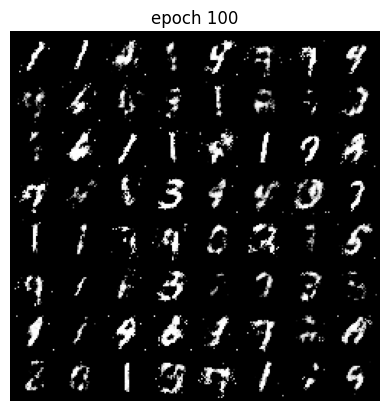

Epoch 100 of 100
Generator loss: 1.96449912, Discriminator loss: 0.81932533


In [16]:
torch.manual_seed(7777)

from torch.autograd import Variable
from torch.autograd import grad as torch_grad

def generator_loss(output, true_label):
    ############ YOUR CODE HERE ##########
    return criterion(output, true_label)
    ######################################

def discriminator_loss(output, true_label):
    ############ YOUR CODE HERE ##########
    return criterion(output, true_label)
    ######################################

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        ############ YOUR CODE HERE ##########
        discriminator.zero_grad()

        real_cpu = data[0].to(device)
        #print(data[0])
        b_size = real_cpu.size(0)
        label = label_real(b_size)
        output1 = discriminator(real_cpu)

        errD_real = discriminator_loss(output1, label)
        errD_real.backward()


        tmp_noise = torch.randn(b_size, nz).to(device)
        fake = generator(tmp_noise)
        label = label_fake(b_size)
        output2 = discriminator(fake.detach())

        # gp = gradient_penalty(output1,output2)
        # gp.backward()

        errD_fake = discriminator_loss(output2, label)
        errD_fake.backward()

        errD = errD_real + errD_fake
        #print(errD)
        optim_d.step()
        loss_d += errD


        #for part b
        # generator.zero_grad()
        # label = label_fake(b_size)
        # output = discriminator(fake)
        # errG = - generator_loss(output,label)
        # errG.backward()
        #for part a
        generator.zero_grad()
        label = label_real(b_size)
        output = discriminator(fake)
        errG = generator_loss(output, label)
        errG.backward()

        optim_g.step()
        loss_g += errG

        ######################################


    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()

    # make the images as grid
    generated_img = make_grid(generated_img)

    # visualize generated images
    if (epoch + 1) % 50 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()

    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img_a{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g.item())
    losses_d.append(epoch_loss_d.item())

    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

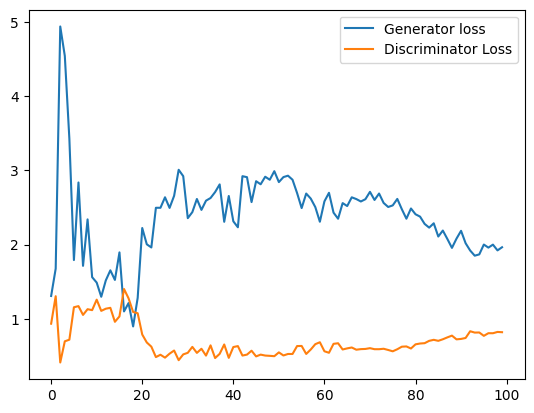

In [17]:
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')

In [ ]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [ ]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

# 1.(b)

118it [00:14,  8.07it/s]                         


Epoch 1 of 100
Generator loss: -0.23315214, Discriminator loss: 0.43413657


118it [00:14,  8.40it/s]                         


Epoch 2 of 100
Generator loss: -0.00003376, Discriminator loss: 0.00006741


118it [00:13,  8.61it/s]                         


Epoch 3 of 100
Generator loss: -0.00003745, Discriminator loss: 0.00006084


118it [00:13,  8.48it/s]                         


Epoch 4 of 100
Generator loss: -0.00003549, Discriminator loss: 0.00004909


118it [00:14,  8.35it/s]                         


Epoch 5 of 100
Generator loss: -0.00003682, Discriminator loss: 0.00005345


118it [00:13,  8.46it/s]                         


Epoch 6 of 100
Generator loss: -0.00004106, Discriminator loss: 0.00005836


118it [00:13,  8.54it/s]                         


Epoch 7 of 100
Generator loss: -0.00138313, Discriminator loss: 0.03448494


118it [00:13,  8.46it/s]                         


Epoch 8 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000494


118it [00:13,  8.55it/s]                         


Epoch 9 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000265


118it [00:13,  8.57it/s]                         


Epoch 10 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000167


118it [00:13,  8.58it/s]


Epoch 11 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000157


118it [00:13,  8.65it/s]                         


Epoch 12 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000096


118it [00:13,  8.60it/s]                         


Epoch 13 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000090


118it [00:13,  8.60it/s]                         


Epoch 14 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000070


118it [00:13,  8.59it/s]                         


Epoch 15 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000076


118it [00:13,  8.48it/s]                         


Epoch 16 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000052


118it [00:13,  8.55it/s]                         


Epoch 17 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000058


118it [00:14,  8.41it/s]                         


Epoch 18 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000040


118it [00:13,  8.63it/s]                         


Epoch 19 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000034


118it [00:13,  8.60it/s]                         


Epoch 20 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000033


118it [00:13,  8.51it/s]                         


Epoch 21 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000029


118it [00:13,  8.59it/s]                         


Epoch 22 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000031


118it [00:13,  8.61it/s]                         


Epoch 23 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000027


118it [00:13,  8.49it/s]                         


Epoch 24 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000022


118it [00:13,  8.52it/s]                         


Epoch 25 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000029


118it [00:14,  8.41it/s]                         


Epoch 26 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000018


118it [00:14,  8.15it/s]                         


Epoch 27 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000017


118it [00:13,  8.47it/s]                         


Epoch 28 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000020


118it [00:13,  8.46it/s]                         


Epoch 29 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000015


118it [00:14,  8.39it/s]                         


Epoch 30 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000025


118it [00:14,  8.26it/s]                         


Epoch 31 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000012


118it [00:14,  8.23it/s]                         


Epoch 32 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000015


118it [00:13,  8.44it/s]                         


Epoch 33 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000010


118it [00:13,  8.57it/s]                         


Epoch 34 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000009


118it [00:13,  8.65it/s]                         


Epoch 35 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000012


118it [00:13,  8.54it/s]                         


Epoch 36 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000008


118it [00:14,  8.32it/s]                         


Epoch 37 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000007


118it [00:14,  8.42it/s]                         


Epoch 38 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000008


118it [00:13,  8.48it/s]                         


Epoch 39 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000007


118it [00:13,  8.49it/s]                         


Epoch 40 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000007


118it [00:13,  8.58it/s]                         


Epoch 41 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000007


118it [00:13,  8.69it/s]                         


Epoch 42 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000006


118it [00:13,  8.46it/s]                         


Epoch 43 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000007


118it [00:14,  8.38it/s]                         


Epoch 44 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000007


118it [00:14,  8.40it/s]                         


Epoch 45 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000005


118it [00:13,  8.55it/s]                         


Epoch 46 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000005


118it [00:13,  8.53it/s]                         


Epoch 47 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000004


118it [00:14,  8.33it/s]                         


Epoch 48 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000004


118it [00:14,  8.34it/s]                         


Epoch 49 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000004


118it [00:13,  8.45it/s]                         


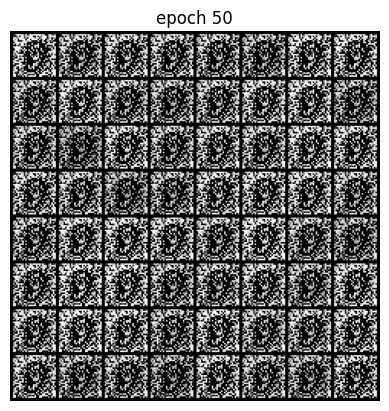

Epoch 50 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000003


118it [00:14,  8.32it/s]                         


Epoch 51 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000003


118it [00:14,  8.42it/s]                         


Epoch 52 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000004


118it [00:13,  8.59it/s]                         


Epoch 53 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000004


118it [00:13,  8.46it/s]                         


Epoch 54 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000004


118it [00:14,  8.26it/s]                         


Epoch 55 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000002


118it [00:14,  8.10it/s]                         


Epoch 56 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000003


118it [00:14,  8.27it/s]                         


Epoch 57 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000002


118it [00:14,  8.15it/s]                         


Epoch 58 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000002


118it [00:14,  8.20it/s]                         


Epoch 59 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000002


118it [00:14,  8.10it/s]                         


Epoch 60 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000002


118it [00:14,  8.25it/s]                         


Epoch 61 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000003


118it [00:14,  8.17it/s]                         


Epoch 62 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000001


118it [00:14,  8.09it/s]                         


Epoch 63 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000002


118it [00:14,  8.13it/s]                         


Epoch 64 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000002


118it [00:14,  8.17it/s]                         


Epoch 65 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000002


118it [00:14,  8.08it/s]                         


Epoch 66 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000001


118it [00:14,  8.17it/s]                         


Epoch 67 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000001


118it [00:14,  8.06it/s]                         


Epoch 68 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000001


118it [00:14,  8.21it/s]                         


Epoch 69 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000001


118it [00:14,  8.25it/s]                         


Epoch 70 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000001


118it [00:14,  8.07it/s]                         


Epoch 71 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000001


118it [00:14,  8.18it/s]                         


Epoch 72 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000001


118it [00:14,  8.12it/s]                         


Epoch 73 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000001


118it [00:14,  8.21it/s]                         


Epoch 74 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000001


118it [00:14,  8.04it/s]                         


Epoch 75 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000001


118it [00:14,  8.07it/s]                         


Epoch 76 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000001


118it [00:14,  7.99it/s]                         


Epoch 77 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000001


118it [00:14,  7.88it/s]                         


Epoch 78 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000001


118it [00:14,  8.30it/s]                         


Epoch 79 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000001


118it [00:14,  8.29it/s]                         


Epoch 80 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000001


118it [00:14,  8.35it/s]                         


Epoch 81 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000001


118it [00:14,  8.32it/s]                         


Epoch 82 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000001


118it [00:14,  8.13it/s]                         


Epoch 83 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000001


118it [00:14,  8.25it/s]                         


Epoch 84 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:14,  8.28it/s]                         


Epoch 85 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000001


118it [00:14,  8.23it/s]                         


Epoch 86 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:14,  8.11it/s]                         


Epoch 87 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:14,  8.05it/s]                         


Epoch 88 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:14,  8.04it/s]                         


Epoch 89 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000001


118it [00:14,  8.28it/s]                         


Epoch 90 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:14,  8.19it/s]                         


Epoch 91 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:14,  8.21it/s]                         


Epoch 92 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:14,  8.16it/s]                         


Epoch 93 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:14,  8.01it/s]                         


Epoch 94 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:14,  8.19it/s]                         


Epoch 95 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:14,  8.22it/s]                         


Epoch 96 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:14,  8.33it/s]                         


Epoch 97 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:14,  7.96it/s]                         


Epoch 98 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:14,  8.14it/s]                         


Epoch 99 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:14,  8.29it/s]                         


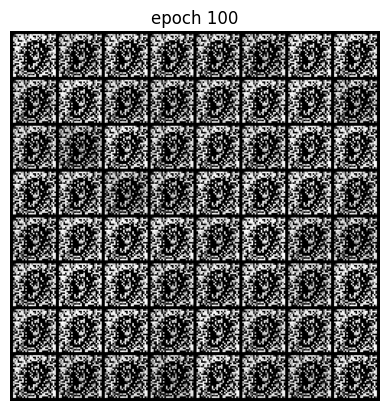

Epoch 100 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


In [18]:


losses_g = [] # to store generator loss after each epoch
losses_d = []

generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

from torch.autograd import Variable
from torch.autograd import grad as torch_grad

def generator_loss(output, true_label):
    ############ YOUR CODE HERE ##########
    return criterion(output, true_label)
    ######################################

def discriminator_loss(output, true_label):
    ############ YOUR CODE HERE ##########
    return criterion(output, true_label)
    ######################################

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        ############ YOUR CODE HERE ##########
        discriminator.zero_grad()

        real_cpu = data[0].to(device)
        #print(data[0])
        b_size = real_cpu.size(0)
        label = label_real(b_size)
        output1 = discriminator(real_cpu)

        errD_real = discriminator_loss(output1, label)
        errD_real.backward()


        tmp_noise = torch.randn(b_size, nz).to(device)
        fake = generator(tmp_noise)
        label = label_fake(b_size)
        output2 = discriminator(fake.detach())

        # gp = gradient_penalty(output1,output2)
        # gp.backward()

        errD_fake = discriminator_loss(output2, label)
        errD_fake.backward()

        errD = errD_real + errD_fake
        #print(errD)
        optim_d.step()
        loss_d += errD


        #for part b
        generator.zero_grad()
        label = label_fake(b_size)
        output = discriminator(fake)
        errG = - generator_loss(output,label)
        errG.backward()
        #for part a
        # generator.zero_grad()
        # label = label_real(b_size)
        # output = discriminator(fake)
        # errG = generator_loss(output, label)
        # errG.backward()

        optim_g.step()
        loss_g += errG

        ######################################


    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()

    # make the images as grid
    generated_img = make_grid(generated_img)

    # visualize generated images
    if (epoch + 1) % 50 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()

    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img_b{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g.item())
    losses_d.append(epoch_loss_d.item())

    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

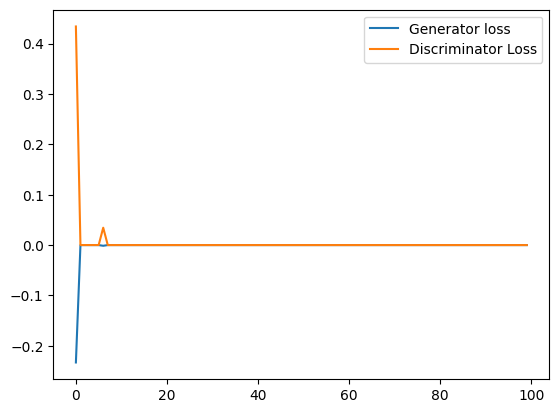

In [19]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss_b.png')

# 1.(c) WGAN + GP

In [20]:
import torch
#import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torchvision.utils import make_grid, save_image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



def assert_shape(tensor, shape):
    try:
        assert len(tensor.shape) == len(shape)

        for a, b in zip(tensor.shape, shape):
            if a == None or b == None:
                continue

            assert a == b

    except:
        raise AssertionError(
            "Tensor has shape {} but expected shape {}".format(tensor.shape, shape))


class Generator(nn.Module):
    def __init__(self, input_size):
        super(Generator, self).__init__()
        self.input_size = input_size

        self.fc1 = nn.Linear(input_size, 5*5*256, bias = False)
        self.bn1 = nn.BatchNorm1d(5*5*256)

        self.conv1 = nn.ConvTranspose2d(256, 128, 4, bias = False, stride=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv2 = nn.ConvTranspose2d(128, 64, 4, stride=2, bias = False, padding=2)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv3 = nn.ConvTranspose2d(64, 1, 4, stride=2, bias = True, padding=1)

    def forward(self, x):
        assert_shape(x, (None, self.input_size, 1, 1))

        x = x.view(-1, self.input_size)
        x = F.leaky_relu(self.bn1(self.fc1(x)))
        x = x.view(-1, 256, 5, 5)
        x = F.leaky_relu(self.bn2(self.conv1(x)))
        x = F.leaky_relu(self.bn3(self.conv2(x)))
        x = self.conv3(x)

        assert_shape(x, (None, 1, 28, 28))

        return x
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, 5, stride=2, padding=2)
        self.dropout1 = nn.Dropout(p=0.3)

        self.conv2 = nn.Conv2d(64, 128, 5, stride=2, padding=2)
        self.dropout2 = nn.Dropout(p=0.3)

        self.fc1 = nn.Linear(7*7*128, 1)

    def forward(self, x):
        x = self.dropout1(F.leaky_relu(self.conv1(x)))
        x = self.dropout2(F.leaky_relu(self.conv2(x)))
        x = self.fc1(x.view(-1, 7*7*128))

        return x


def save_generator_image(image, path):
    save_image(image, path)


In [21]:
nz = 128

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Make input, output folders
# !mkdir -p input
# !mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=512, shuffle=True)





generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)


optim_g = optim.RMSprop(generator.parameters(), lr=1e-4)
optim_d = optim.RMSprop(discriminator.parameters(), lr=1e-4)

def sample_noise(batch_size, *channels):
    return torch.randn(batch_size, *channels).float()

def clip_weights(parameters, value):  # bad
    for param in parameters:
        param.data.clamp_(-value, value)


train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform)
noise_size = 128
noise_fix = sample_noise(64, noise_size, 1, 1).to(device)

118it [00:23,  4.92it/s]


Epoch 1 of 100
Generator loss: 8.82644272, Discriminator loss: -12.26769161


118it [00:17,  6.56it/s]                         


Epoch 2 of 100
Generator loss: 3.08319831, Discriminator loss: -6.82393360


118it [00:17,  6.58it/s]                         


Epoch 3 of 100
Generator loss: 1.78196836, Discriminator loss: -8.39663696


118it [00:18,  6.37it/s]                         


Epoch 4 of 100
Generator loss: 0.50398332, Discriminator loss: -8.18680573


118it [00:18,  6.49it/s]                         


Epoch 5 of 100
Generator loss: 2.87394762, Discriminator loss: -7.08625984


118it [00:18,  6.54it/s]                         


Epoch 6 of 100
Generator loss: 2.92932701, Discriminator loss: -5.99427605


118it [00:18,  6.33it/s]                         


Epoch 7 of 100
Generator loss: 2.19898391, Discriminator loss: -4.81156158


118it [00:18,  6.39it/s]                         


Epoch 8 of 100
Generator loss: 1.51814306, Discriminator loss: -4.29854870


118it [00:17,  6.66it/s]                         


Epoch 9 of 100
Generator loss: 1.38084781, Discriminator loss: -4.19337130


118it [00:18,  6.31it/s]                         


Epoch 10 of 100
Generator loss: 1.37909210, Discriminator loss: -4.34952021


118it [00:18,  6.53it/s]                         


Epoch 11 of 100
Generator loss: 1.54112697, Discriminator loss: -4.57778358


118it [00:17,  6.58it/s]                         


Epoch 12 of 100
Generator loss: 1.76201487, Discriminator loss: -4.78326416


118it [00:18,  6.33it/s]                         


Epoch 13 of 100
Generator loss: 1.78679454, Discriminator loss: -5.02643681


118it [00:17,  6.61it/s]                         


Epoch 14 of 100
Generator loss: 1.83932149, Discriminator loss: -5.18180132


118it [00:18,  6.55it/s]                         


Epoch 15 of 100
Generator loss: 1.54789805, Discriminator loss: -5.35505199


118it [00:18,  6.21it/s]                         


Epoch 16 of 100
Generator loss: 1.41861606, Discriminator loss: -5.49801397


118it [00:18,  6.53it/s]                         


Epoch 17 of 100
Generator loss: 1.41698050, Discriminator loss: -5.61344194


118it [00:18,  6.48it/s]                         


Epoch 18 of 100
Generator loss: 1.34504724, Discriminator loss: -5.71980906


118it [00:18,  6.40it/s]                         


Epoch 19 of 100
Generator loss: 1.62417364, Discriminator loss: -5.82459164


118it [00:17,  6.56it/s]                         


Epoch 20 of 100
Generator loss: 1.45534682, Discriminator loss: -5.89356089


118it [00:18,  6.44it/s]                         


Epoch 21 of 100
Generator loss: 1.76016903, Discriminator loss: -6.00152874


118it [00:18,  6.41it/s]                         


Epoch 22 of 100
Generator loss: 1.64330947, Discriminator loss: -6.03046083


118it [00:17,  6.56it/s]                         


Epoch 23 of 100
Generator loss: 1.87056231, Discriminator loss: -6.12662029


118it [00:18,  6.35it/s]                         


Epoch 24 of 100
Generator loss: 1.91091466, Discriminator loss: -6.18770266


118it [00:18,  6.49it/s]                         


Epoch 25 of 100
Generator loss: 2.18397093, Discriminator loss: -6.22266912


118it [00:18,  6.53it/s]                         


Epoch 26 of 100
Generator loss: 2.21767402, Discriminator loss: -6.21428823


118it [00:18,  6.37it/s]                         


Epoch 27 of 100
Generator loss: 2.31008053, Discriminator loss: -6.21539593


118it [00:18,  6.43it/s]                         


Epoch 28 of 100
Generator loss: 2.49994373, Discriminator loss: -6.19784164


118it [00:18,  6.50it/s]                         


Epoch 29 of 100
Generator loss: 2.41422534, Discriminator loss: -6.12920570


118it [00:18,  6.24it/s]                         


Epoch 30 of 100
Generator loss: 2.36403799, Discriminator loss: -6.08294249


118it [00:18,  6.48it/s]                         


Epoch 31 of 100
Generator loss: 2.69803882, Discriminator loss: -6.02230930


118it [00:18,  6.46it/s]                         


Epoch 32 of 100
Generator loss: 2.46427727, Discriminator loss: -5.95873356


118it [00:18,  6.23it/s]                         


Epoch 33 of 100
Generator loss: 2.59360123, Discriminator loss: -5.90418482


118it [00:18,  6.50it/s]                         


Epoch 34 of 100
Generator loss: 2.48513436, Discriminator loss: -5.80901289


118it [00:18,  6.47it/s]                         


Epoch 35 of 100
Generator loss: 2.53166342, Discriminator loss: -5.77249908


118it [00:18,  6.30it/s]                         


Epoch 36 of 100
Generator loss: 2.45127463, Discriminator loss: -5.68258142


118it [00:17,  6.62it/s]                         


Epoch 37 of 100
Generator loss: 2.55751300, Discriminator loss: -5.61544466


118it [00:18,  6.53it/s]                         


Epoch 38 of 100
Generator loss: 2.52175188, Discriminator loss: -5.56918097


118it [00:19,  6.20it/s]                         


Epoch 39 of 100
Generator loss: 2.33453584, Discriminator loss: -5.49927330


118it [00:18,  6.51it/s]                         


Epoch 40 of 100
Generator loss: 2.49823928, Discriminator loss: -5.46169329


118it [00:18,  6.39it/s]                         


Epoch 41 of 100
Generator loss: 2.44295883, Discriminator loss: -5.40945196


118it [00:18,  6.43it/s]                         


Epoch 42 of 100
Generator loss: 2.48019361, Discriminator loss: -5.34581137


118it [00:18,  6.52it/s]                         


Epoch 43 of 100
Generator loss: 2.45276022, Discriminator loss: -5.32108021


118it [00:18,  6.27it/s]                         


Epoch 44 of 100
Generator loss: 2.34942889, Discriminator loss: -5.24384260


118it [00:18,  6.48it/s]                         


Epoch 45 of 100
Generator loss: 2.30220771, Discriminator loss: -5.21650982


118it [00:18,  6.45it/s]                         


Epoch 46 of 100
Generator loss: 2.11459136, Discriminator loss: -5.14364624


118it [00:19,  6.13it/s]                         


Epoch 47 of 100
Generator loss: 2.23374820, Discriminator loss: -5.11355400


118it [00:18,  6.50it/s]                         


Epoch 48 of 100
Generator loss: 2.12650156, Discriminator loss: -5.06186199


118it [00:18,  6.38it/s]                         


Epoch 49 of 100
Generator loss: 2.09751225, Discriminator loss: -5.01607752


118it [00:18,  6.31it/s]                         


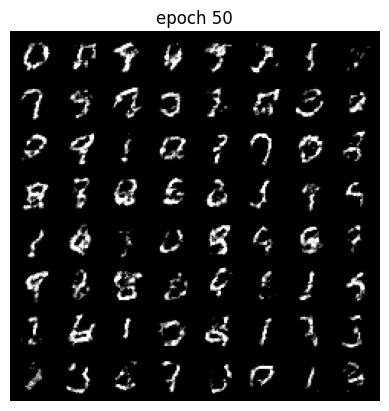

Epoch 50 of 100
Generator loss: 1.90242648, Discriminator loss: -4.96108675


118it [00:18,  6.48it/s]                         


Epoch 51 of 100
Generator loss: 1.86934710, Discriminator loss: -4.91229725


118it [00:18,  6.36it/s]                         


Epoch 52 of 100
Generator loss: 1.92698932, Discriminator loss: -4.87031651


118it [00:18,  6.46it/s]                         


Epoch 53 of 100
Generator loss: 1.81020164, Discriminator loss: -4.82351160


118it [00:18,  6.50it/s]                         


Epoch 54 of 100
Generator loss: 1.81987834, Discriminator loss: -4.80287504


118it [00:18,  6.27it/s]                         


Epoch 55 of 100
Generator loss: 1.76125884, Discriminator loss: -4.74213934


118it [00:18,  6.48it/s]                         


Epoch 56 of 100
Generator loss: 1.81450593, Discriminator loss: -4.69647503


118it [00:17,  6.57it/s]                         


Epoch 57 of 100
Generator loss: 1.78877592, Discriminator loss: -4.66296291


118it [00:18,  6.33it/s]                         


Epoch 58 of 100
Generator loss: 1.73773599, Discriminator loss: -4.61974955


118it [00:17,  6.57it/s]                         


Epoch 59 of 100
Generator loss: 1.74765611, Discriminator loss: -4.59913015


118it [00:18,  6.55it/s]                         


Epoch 60 of 100
Generator loss: 1.59510171, Discriminator loss: -4.51775312


118it [00:18,  6.34it/s]                         


Epoch 61 of 100
Generator loss: 1.50311470, Discriminator loss: -4.47281170


118it [00:18,  6.47it/s]                         


Epoch 62 of 100
Generator loss: 1.51968372, Discriminator loss: -4.44857645


118it [00:17,  6.61it/s]                         


Epoch 63 of 100
Generator loss: 1.54232490, Discriminator loss: -4.41580677


118it [00:18,  6.31it/s]                         


Epoch 64 of 100
Generator loss: 1.53991771, Discriminator loss: -4.37961006


118it [00:17,  6.57it/s]                         


Epoch 65 of 100
Generator loss: 1.53235340, Discriminator loss: -4.36645746


118it [00:18,  6.55it/s]                         


Epoch 66 of 100
Generator loss: 1.33329415, Discriminator loss: -4.31882191


118it [00:18,  6.31it/s]                         


Epoch 67 of 100
Generator loss: 1.34999597, Discriminator loss: -4.29861498


118it [00:17,  6.58it/s]                         


Epoch 68 of 100
Generator loss: 1.39427495, Discriminator loss: -4.27896261


118it [00:18,  6.49it/s]                         


Epoch 69 of 100
Generator loss: 1.26530671, Discriminator loss: -4.25062752


118it [00:18,  6.25it/s]                         


Epoch 70 of 100
Generator loss: 1.33484972, Discriminator loss: -4.22438335


118it [00:17,  6.62it/s]                         


Epoch 71 of 100
Generator loss: 1.25028145, Discriminator loss: -4.19656706


118it [00:18,  6.46it/s]                         


Epoch 72 of 100
Generator loss: 1.27210569, Discriminator loss: -4.17901182


118it [00:18,  6.40it/s]                         


Epoch 73 of 100
Generator loss: 1.16397488, Discriminator loss: -4.15209866


118it [00:18,  6.52it/s]                         


Epoch 74 of 100
Generator loss: 1.19544864, Discriminator loss: -4.13089895


118it [00:18,  6.41it/s]                         


Epoch 75 of 100
Generator loss: 1.13878083, Discriminator loss: -4.09310675


118it [00:18,  6.49it/s]                         


Epoch 76 of 100
Generator loss: 1.06786704, Discriminator loss: -4.07614422


118it [00:18,  6.46it/s]                         


Epoch 77 of 100
Generator loss: 0.92608619, Discriminator loss: -4.05070162


118it [00:18,  6.24it/s]                         


Epoch 78 of 100
Generator loss: 0.78957075, Discriminator loss: -4.02376413


118it [00:18,  6.49it/s]                         


Epoch 79 of 100
Generator loss: 0.97527945, Discriminator loss: -4.00960064


118it [00:18,  6.52it/s]                         


Epoch 80 of 100
Generator loss: 0.93553150, Discriminator loss: -4.00505018


118it [00:18,  6.26it/s]                         


Epoch 81 of 100
Generator loss: 1.01526237, Discriminator loss: -3.96178842


118it [00:18,  6.51it/s]                         


Epoch 82 of 100
Generator loss: 0.76498449, Discriminator loss: -3.93752193


118it [00:17,  6.58it/s]                         


Epoch 83 of 100
Generator loss: 0.92841995, Discriminator loss: -3.93076921


118it [00:19,  6.17it/s]                         


Epoch 84 of 100
Generator loss: 0.79675931, Discriminator loss: -3.89020658


118it [00:17,  6.60it/s]                         


Epoch 85 of 100
Generator loss: 0.89408112, Discriminator loss: -3.87910938


118it [00:18,  6.46it/s]                         


Epoch 86 of 100
Generator loss: 0.88216531, Discriminator loss: -3.88351607


118it [00:18,  6.30it/s]                         


Epoch 87 of 100
Generator loss: 0.78215539, Discriminator loss: -3.83897614


118it [00:17,  6.59it/s]                         


Epoch 88 of 100
Generator loss: 0.77335560, Discriminator loss: -3.82047105


118it [00:18,  6.51it/s]                         


Epoch 89 of 100
Generator loss: 0.73053420, Discriminator loss: -3.80122781


118it [00:18,  6.33it/s]                         


Epoch 90 of 100
Generator loss: 0.77368677, Discriminator loss: -3.78844047


118it [00:17,  6.56it/s]                         


Epoch 91 of 100
Generator loss: 0.77513587, Discriminator loss: -3.78796911


118it [00:18,  6.42it/s]                         


Epoch 92 of 100
Generator loss: 0.74534750, Discriminator loss: -3.74089313


118it [00:18,  6.42it/s]                         


Epoch 93 of 100
Generator loss: 0.68811268, Discriminator loss: -3.74207449


118it [00:17,  6.58it/s]                         


Epoch 94 of 100
Generator loss: 0.65385872, Discriminator loss: -3.72617912


118it [00:18,  6.44it/s]                         


Epoch 95 of 100
Generator loss: 0.66946435, Discriminator loss: -3.70879793


118it [00:18,  6.43it/s]                         


Epoch 96 of 100
Generator loss: 0.65189689, Discriminator loss: -3.69564247


118it [00:17,  6.58it/s]                         


Epoch 97 of 100
Generator loss: 0.58284342, Discriminator loss: -3.67041850


118it [00:18,  6.41it/s]                         


Epoch 98 of 100
Generator loss: 0.54666269, Discriminator loss: -3.65023708


118it [00:18,  6.37it/s]                         


Epoch 99 of 100
Generator loss: 0.49718910, Discriminator loss: -3.63388515


118it [00:17,  6.60it/s]                         


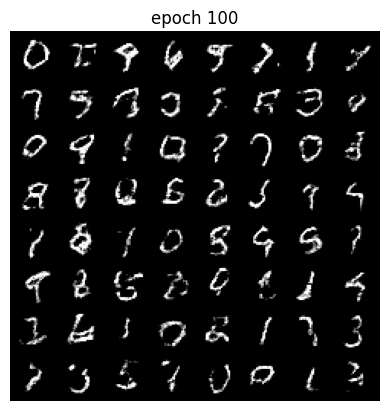

Epoch 100 of 100
Generator loss: 0.55802405, Discriminator loss: -3.65044618


In [22]:
epochs = 100
noise_size = nz
critic_steps = 5



G_losses = []
D_losses = []
for epoch in range(epochs):
    g_loss = 0
    g_num = 0
    d_loss = 0
    d_num = 0
    generator.train()
    discriminator.train()

    #for i, (real, labels) in enumerate(train_loader):
    for i, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        # if i < 115:
        #     continue


        bi_size = data[0].size(0)
        #print(bi_size)
        noise = sample_noise(bi_size, noise_size, 1, 1).to(device)
        real = data[0].to(device)

        fake = generator(noise)
        fake_discr = discriminator(fake)
        real_discr = discriminator(real)
        loss = fake_discr.mean() - real_discr.mean()

        # if i % 100 == 0:
        #     print("[INFO] [EPOCH {}] [SAMPLE {}] Wasserstein loss is {}".format(epoch, i, -loss))
            # plotter.plot("loss", "wasserstein", "Loss for Wasserstein GAN", len(
            #     train_loader) * epoch + i, -float(loss.detach().cpu()), xlabel="iterations")

        epsilon = torch.FloatTensor(bi_size, 1, 1, 1).uniform_(0, 1).to(device)
        xhat = epsilon * fake + (1 - epsilon) * real

        xhat_discr = discriminator(xhat)
        grads = torch.autograd.grad(xhat_discr, xhat, grad_outputs=torch.ones_like(xhat_discr), create_graph=True)[0]

        penalty = ((torch.sqrt((grads ** 2).sum(dim=(1, 2, 3))) - 1) ** 2).mean()
        loss = loss + 10 * penalty

        d_loss += loss * bi_size
        d_num += bi_size

        optim_d.zero_grad()
        loss.backward()
        optim_d.step()

        if i % critic_steps == 0:
            noise = sample_noise(bi_size, noise_size, 1, 1).to(device)
            loss = - discriminator(generator(noise)).mean()


            g_loss += loss * bi_size
            g_num += bi_size
            optim_g.zero_grad()
            loss.backward()

            optim_g.step()

            # if i % (10 * critic_steps) == 0:
            #     print("[INFO] [EPOCH {}] [SAMPLE {}] Generator loss is {}".format(epoch, i, loss))
                # plotter.plot("loss", "generator", "Loss for Wasserstein GAN", len(
                #     train_loader) * epoch + i, float(loss.detach().cpu()), xlabel="iterations")
    epoch_loss_d = d_loss / d_num
    epoch_loss_g = g_loss / g_num
    D_losses.append(  epoch_loss_d.item())
    G_losses.append(epoch_loss_g.item())

    generated_img = generator(noise_fix).cpu().detach()

        # make the images as grid
    generated_img = make_grid(generated_img)

    # visualize generated images
    if (epoch + 1) % 50 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()

    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img_wgan{epoch+1}.png")

    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

np.savetxt('outputs/Gloss.txt',G_losses)
np.savetxt('outputs/Dloss.txt',D_losses)


In [23]:
losses_g = np.loadtxt('outputs/Gloss.txt')
losses_d = np.loadtxt('outputs/Dloss.txt')

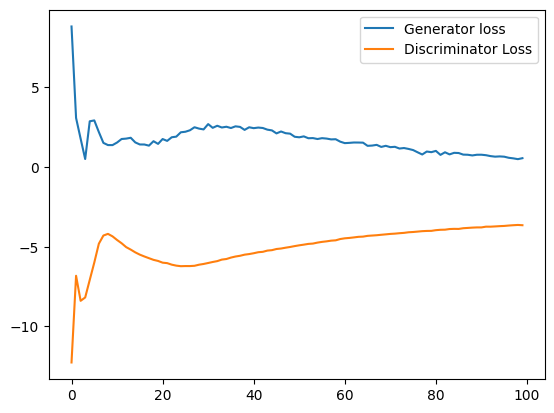

In [25]:
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss_wgan.png')
plt.show()